In [44]:
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = pd.read_table('names.txt', header = None, names = ['name'])
words

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia
...,...
32028,zylas
32029,zyran
32030,zyrie
32031,zyron


In [14]:
# smallest name
words['name'].apply(lambda x: len(x)).min()

2

In [15]:
# largest name length
words['name'].apply(lambda x: len(x)).max()

15

In [25]:
# separate into bigrams (with extra for starting and ending letters)
b = {}
for word in words['name']:
    # hallucinate a special start token
    chars = ['<S>'] + list(word) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [30]:
sorted(b.items(), key = lambda x: x[1], reverse = True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [35]:
# initialize 28 x 28 matrix (26 letters + start + end) for all possible combinations
a = torch.zeros((28, 28), dtype = torch.int32)

In [39]:
characters = sorted(list(set(''.join(words['name']))))
char2idx = {c: i for i, c in enumerate(characters)}
char2idx['<S>'] = 26
char2idx['<E>'] = 27

In [41]:
characters = sorted(list(set(''.join(words['name']))))
# separate into bigrams (with extra for starting and ending letters)
for word in words['name']:
    # hallucinate a special start token
    chars = ['<S>'] + list(word) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        starting_letter = char2idx[ch1]
        ending_letter = char2idx[ch2]
        a[starting_letter, ending_letter] += 1

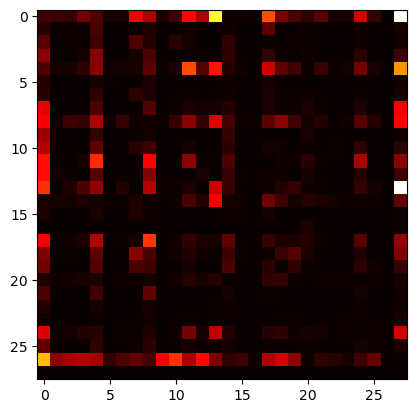

In [45]:
# show the heatmap
plt.imshow(a, cmap = 'hot', interpolation = 'nearest')

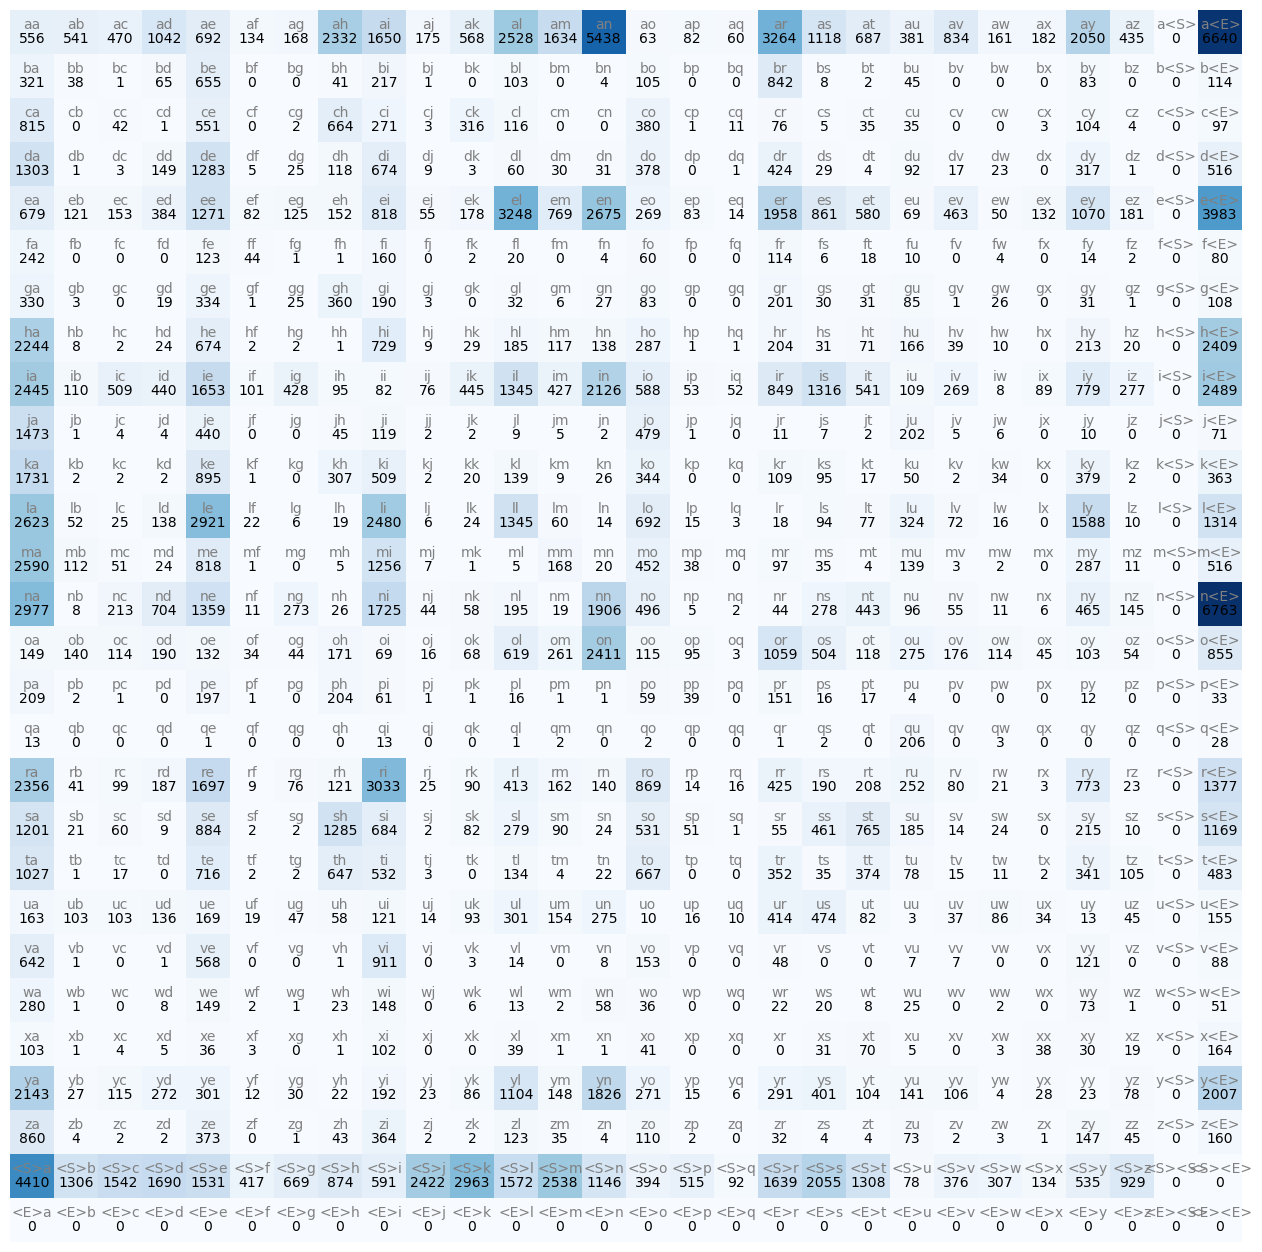

In [54]:
itos = {i:c for c, i in char2idx.items()}

plt.figure(figsize = (16, 16))
plt.imshow(a, cmap = "Blues")
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'gray')
        plt.text(j, i, a[i, j].item(), ha = 'center', va = 'top', color = 'black')

plt.axis('off');